In [1]:
# https://github.com/srikeshnagoji/unet3p-attn/tree/unet-3p-with-attention-rearch-v2

In [2]:
# # DO 

# !pip uninstall Albumentations
# !pip install Albumentations==0.5.2

In [3]:
# Dice link: https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388

In [4]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")
%matplotlib inline


In [73]:
from prepareData.prepareData import get_dataset_dataframe
from util.helper import pos_neg_diagnosis, show_aug, train_model, plot_model_history, viz_pred_output
from prepareData import augmentData, customDatasetObject
from model.unet3p_attention import UNet_3Plus_attn
from model.unet3p import UNet3Plus
from model.unet_attention import AttentionUNet
from metrics.diceMetrics import dice_coef_metric, DiceLoss, compute_iou


In [6]:
BASE_PATH= "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m"

In [7]:
BASE_LEN = len(BASE_PATH) + len("/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")
END_LEN = len(".tif")
END_MASK_LEN = len("_mask.tif")

IMG_SIZE = 512

# Prepare data

In [8]:
df = get_dataset_dataframe(BASE_PATH)

[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/data.csv
[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/README.md


In [9]:
df

,dir_name,image_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
...,...,...
7853,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7854,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7855,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7856,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [10]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [11]:
df_imgs.iloc[0,1][BASE_LEN: -END_LEN]

'9'

In [12]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int((x[BASE_LEN: -END_LEN])))
masks = sorted(df_masks["image_path"].values, key=lambda x: int((x[BASE_LEN: -END_MASK_LEN])))

In [13]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_7.tif*
 Belongs to the mask */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_7_mask.tif*


In [14]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [15]:
dff.iloc[0,1]

'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1.tif'

In [16]:
dff.iloc[0,2]


'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1_mask.tif'

In [17]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0


In [18]:
dff.shape


(3929, 4)

In [19]:
dff.diagnosis.value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [20]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

from sklearn.model_selection import train_test_split

In [22]:
import platform
import sklearn as sk
import sys
has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.0.1-arm64-arm-64bit
PyTorch Version: 1.12.1

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


# Split Data and DataLoaders

In [23]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [24]:
train_dataset = customDatasetObject.BrainMRIDataset(train_df, transform=augmentData.transform)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = customDatasetObject.BrainMRIDataset(val_df, transform=augmentData.transform)
val_dataloader = DataLoader(val_dataset, batch_size=10,  shuffle=True)

test_dataset = customDatasetObject.BrainMRIDataset(test_df, transform=augmentData.transform)
test_dataloader = DataLoader(test_dataset, batch_size=10,shuffle=True)

In [25]:
len(train_dataset)

3111

In [26]:
len(val_dataset)

393

In [27]:
len(test_dataset)

425

torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


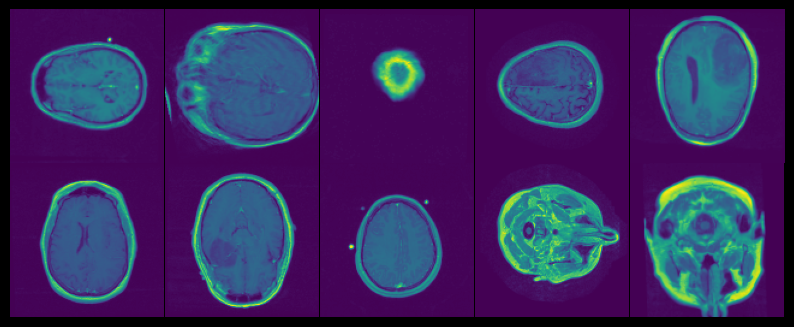

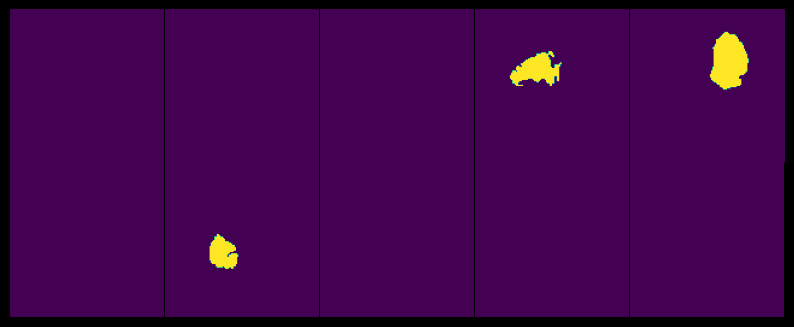

In [28]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

In [29]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

In [30]:
# sanity check
DiceLoss()(F.sigmoid(torch.tensor([0.7, 1., 1.])), 
              torch.tensor([1.,1.,1.]))

/Users/srikeshnagoji/miniforge3/envs/capstone/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1419)

# U-NET 3+ with attention

In [31]:

unet3p_attn = UNet_3Plus_attn(n_classes=1).to(device)

In [32]:
# Training

In [33]:
# PATH = "model_unet_3p_attn.pt"



In [34]:
opt_unet_3p_attn = torch.optim.Adamax(unet3p_attn.parameters(), lr=1e-4)


In [35]:
# ckp_path = "path/to/checkpoint/checkpoint.pt"


In [36]:
# %%time
num_ep = 120
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_3p_attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p_attn, False, num_ep, device=device)

total params of UNet_3p_attn model: 28043917
trainable params of UNet_3p_attn model: 28043917
[INFO] Model is initializing... UNet_3p_attn


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.5179927047246542 
Mean DICE on train: 0.516112053841808 
Mean DICE on validation: 0.6691577371773514


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.34918265560498607 
Mean DICE on train: 0.6652262172026605 
Mean DICE on validation: 0.6937260835250404


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.32096318422983855 
Mean DICE on train: 0.6882418950885608 
Mean DICE on validation: 0.7364696692516697


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.2933287114287034 
Mean DICE on train: 0.7117797858987103 
Mean DICE on validation: 0.7590978504427311


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.28101177246142656 
Mean DICE on train: 0.7282154894576036 
Mean DICE on validation: 0.7192910593593306


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.273352759770858 
Mean DICE on train: 0.7364564404201915 
Mean DICE on validation: 0.7436062271827867


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.24834934507425016 
Mean DICE on train: 0.7557452061238883 
Mean DICE on validation: 0.7056672012210436


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.24042137884176695 
Mean DICE on train: 0.7651772786190364 
Mean DICE on validation: 0.7884184875686869


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.23798752232239798 
Mean DICE on train: 0.7658413344279668 
Mean DICE on validation: 0.7178318580043354


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.2301366375042842 
Mean DICE on train: 0.7739657699568812 
Mean DICE on validation: 0.7631438727104527


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.22245542819683367 
Mean DICE on train: 0.7897812928647778 
Mean DICE on validation: 0.7767941719845952


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.21114453042928988 
Mean DICE on train: 0.7931587632068915 
Mean DICE on validation: 0.7878624865992019


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.22401396414408317 
Mean DICE on train: 0.7787505077476785 
Mean DICE on validation: 0.8097178009255946


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.2111211610146058 
Mean DICE on train: 0.7931068179382025 
Mean DICE on validation: 0.8131883327422672


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.20418960677507597 
Mean DICE on train: 0.7984342163505966 
Mean DICE on validation: 0.7572828800453991


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.20632836165336463 
Mean DICE on train: 0.8045222193231851 
Mean DICE on validation: 0.8112561297621145


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.19694792326444235 
Mean DICE on train: 0.8073212116468553 
Mean DICE on validation: 0.8056322056495258


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.19993502933245438 
Mean DICE on train: 0.8067814403950978 
Mean DICE on validation: 0.8135896064874222


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.20849363410320038 
Mean DICE on train: 0.7934047950199058 
Mean DICE on validation: 0.8121621479446554


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.1970181195781781 
Mean DICE on train: 0.8069708675946142 
Mean DICE on validation: 0.861698339275963


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.1830882815978466 
Mean DICE on train: 0.8223113272537651 
Mean DICE on validation: 0.831540299363345


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.1865446932422809 
Mean DICE on train: 0.8228047281890832 
Mean DICE on validation: 0.8523270737536693


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.19139181077480316 
Mean DICE on train: 0.8159284879587023 
Mean DICE on validation: 0.7856764151895798


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.17667730840352866 
Mean DICE on train: 0.8261999500440665 
Mean DICE on validation: 0.8153766470583599


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.18423920659682688 
Mean DICE on train: 0.8186306414785296 
Mean DICE on validation: 0.8289071050920384


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.18211844181403136 
Mean DICE on train: 0.8259154166051628 
Mean DICE on validation: 0.8036052640342674


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.19267622094887954 
Mean DICE on train: 0.8181687827955157 
Mean DICE on validation: 0.8264374876589458


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.17242763057733193 
Mean DICE on train: 0.8320733174988718 
Mean DICE on validation: 0.8123947525527728


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.18161128843441987 
Mean DICE on train: 0.8231491349441676 
Mean DICE on validation: 0.7887059508548196


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.17930823545425367 
Mean DICE on train: 0.823283906910448 
Mean DICE on validation: 0.7915263901599704


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.17774836222330728 
Mean DICE on train: 0.8251259282658437 
Mean DICE on validation: 0.8405823569750022


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.17630063131069526 
Mean DICE on train: 0.8268323533030337 
Mean DICE on validation: 0.786937020119196


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.1751438490091226 
Mean DICE on train: 0.8285501021240501 
Mean DICE on validation: 0.7868880346869049


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.16973378413762802 
Mean DICE on train: 0.8320700894116602 
Mean DICE on validation: 0.8190642487698472


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.1720087182445404 
Mean DICE on train: 0.8310307900642356 
Mean DICE on validation: 0.8240162750067993


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.1637235912374961 
Mean DICE on train: 0.8373106948263376 
Mean DICE on validation: 0.8352331230259771


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.16938231770808881 
Mean DICE on train: 0.8332828239708382 
Mean DICE on validation: 0.8031577665085267


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.1712855177047925 
Mean DICE on train: 0.8321615924920087 
Mean DICE on validation: 0.8383019992426509


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.16687107525574854 
Mean DICE on train: 0.8362785977817162 
Mean DICE on validation: 0.8361079581376197


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.17348230725679642 
Mean DICE on train: 0.8297332533823402 
Mean DICE on validation: 0.8124029451536164


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.16258907814820608 
Mean DICE on train: 0.8406465259307608 
Mean DICE on validation: 0.8363286502746339


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.16846905094690812 
Mean DICE on train: 0.8339212426725083 
Mean DICE on validation: 0.8347355392564273


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.17345124597732836 
Mean DICE on train: 0.8274633243326559 
Mean DICE on validation: 0.8352742652942785


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.16134560471161818 
Mean DICE on train: 0.8404044640694861 
Mean DICE on validation: 0.8540043861329397


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.16156855607644105 
Mean DICE on train: 0.8407618227150178 
Mean DICE on validation: 0.8366061345937266


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.16619484948042113 
Mean DICE on train: 0.8343026349080407 
Mean DICE on validation: 0.8253185039387475


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.15682414498848793 
Mean DICE on train: 0.8458995632850382 
Mean DICE on validation: 0.8510867085458218


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.14735811948776245 
Mean DICE on train: 0.8567424322161407 
Mean DICE on validation: 0.8047025356921803


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.14983209757468638 
Mean DICE on train: 0.8522782682655973 
Mean DICE on validation: 0.8458051980623901


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.1448314761122068 
Mean DICE on train: 0.8561836715717911 
Mean DICE on validation: 0.8588801523282603


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [50]
Mean loss on train: 0.1662807006102342 
Mean DICE on train: 0.8347627103823984 
Mean DICE on validation: 0.8184187492529212


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [51]
Mean loss on train: 0.1552594686165834 
Mean DICE on train: 0.8478804875595588 
Mean DICE on validation: 0.814179738677509


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [52]
Mean loss on train: 0.13462342207248396 
Mean DICE on train: 0.867564213210589 
Mean DICE on validation: 0.8621828192381412


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [53]
Mean loss on train: 0.14083396719816405 
Mean DICE on train: 0.863929655488189 
Mean DICE on validation: 0.8302203442932186


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [54]
Mean loss on train: 0.13903918442053673 
Mean DICE on train: 0.8628540996950493 
Mean DICE on validation: 0.8777488297066708


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [55]
Mean loss on train: 0.1359303035797217 
Mean DICE on train: 0.8655155625739019 
Mean DICE on validation: 0.8827853271600026


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [56]
Mean loss on train: 0.1514733055463204 
Mean DICE on train: 0.8497992641190987 
Mean DICE on validation: 0.84055773334735


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [57]
Mean loss on train: 0.13833116529843745 
Mean DICE on train: 0.8632618968406237 
Mean DICE on validation: 0.8327119932194432


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [58]
Mean loss on train: 0.15056449595170143 
Mean DICE on train: 0.8509429802555647 
Mean DICE on validation: 0.8453733192024822


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [59]
Mean loss on train: 0.13673633432541138 
Mean DICE on train: 0.864881501959215 
Mean DICE on validation: 0.8509737410309293


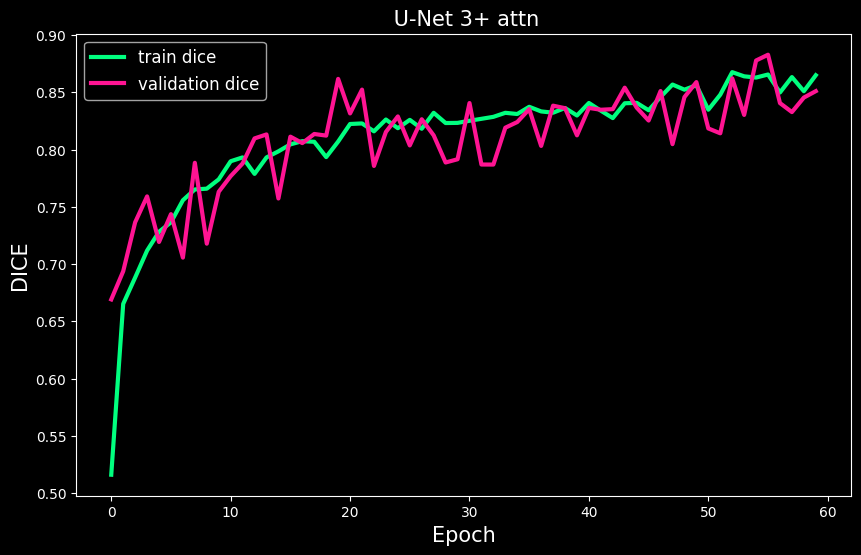

In [37]:
plot_model_history(" U-Net 3+ attn", aun_th, aun_vh, num_ep)

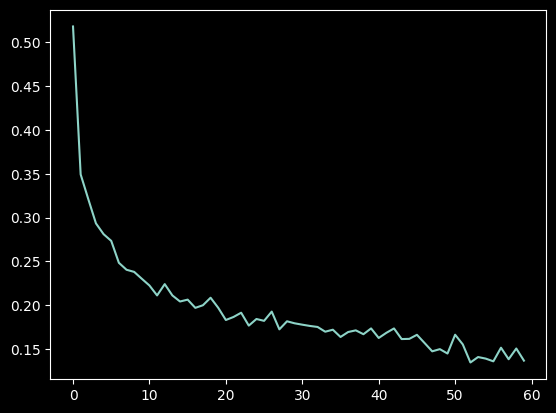

In [38]:
plt.plot(range(num_ep), aun_lh)

In [39]:
test_iou = compute_iou(unet3p_attn, test_dataloader, device)
print(f"""U-Net 3+ Attention\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

U-Net 3+ Attention
Mean IoU of the test images - 82.0%


In [40]:
aun_lh_prev, aun_th_prev, aun_vh_prev = aun_lh, aun_th, aun_vh

In [42]:
last_num_ep = num_ep

In [75]:
# TODO:
# Save losses
# last epoch

In [ ]:
#load prev losses if any
#get last epoch

In [74]:
ckp_path = "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/v3_pytorch_refactored/checkpoints/UNet_3p_attn/checkpoint.pt"
aun_lh, aun_th, aun_vh = train_model("UNet_3p_attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p_attn, False, 10, device=device, ckp_path=ckp_path )

total params of UNet_3p_attn model: 28043917
trainable params of UNet_3p_attn model: 28043917
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 79 number of epochs...
Train for 10 more epochs...
[INFO] Model is initializing... UNet_3p_attn


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [80]
Mean loss on train: 0.13926713187725115 
Mean DICE on train: 0.8632294178417919 
Mean DICE on validation: 0.866123568694712


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [81]
Mean loss on train: 0.1303469030520855 
Mean DICE on train: 0.8706225701957859 
Mean DICE on validation: 0.8599459344473613


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [82]
Mean loss on train: 0.11845130893664482 
Mean DICE on train: 0.8830861791068062 
Mean DICE on validation: 0.858319493614554


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [83]
Mean loss on train: 0.1284961780676475 
Mean DICE on train: 0.87364797459889 
Mean DICE on validation: 0.8383880473664254


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [84]
Mean loss on train: 0.12139113018145928 
Mean DICE on train: 0.8800441313181215 
Mean DICE on validation: 0.8695735188761855


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [85]
Mean loss on train: 0.12268301768180652 
Mean DICE on train: 0.8789753673916899 
Mean DICE on validation: 0.8700214527900152


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [86]
Mean loss on train: 0.12024912639306141 
Mean DICE on train: 0.8819916458196232 
Mean DICE on validation: 0.8496807791315706


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [87]
Mean loss on train: 0.11987242350975673 
Mean DICE on train: 0.8817860539357749 
Mean DICE on validation: 0.8656366138034907


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [88]
Mean loss on train: 0.12362004682803765 
Mean DICE on train: 0.8776443389972233 
Mean DICE on validation: 0.8902223625253988


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [89]
Mean loss on train: 0.13352627861194122 
Mean DICE on train: 0.8685217248680772 
Mean DICE on validation: 0.8541897561859705


In [76]:
aun_lh_prev = aun_lh_prev + aun_lh
aun_th_prev = aun_th_prev + aun_th
aun_vh_prev = aun_vh_prev + aun_vh
last_num_ep = 90

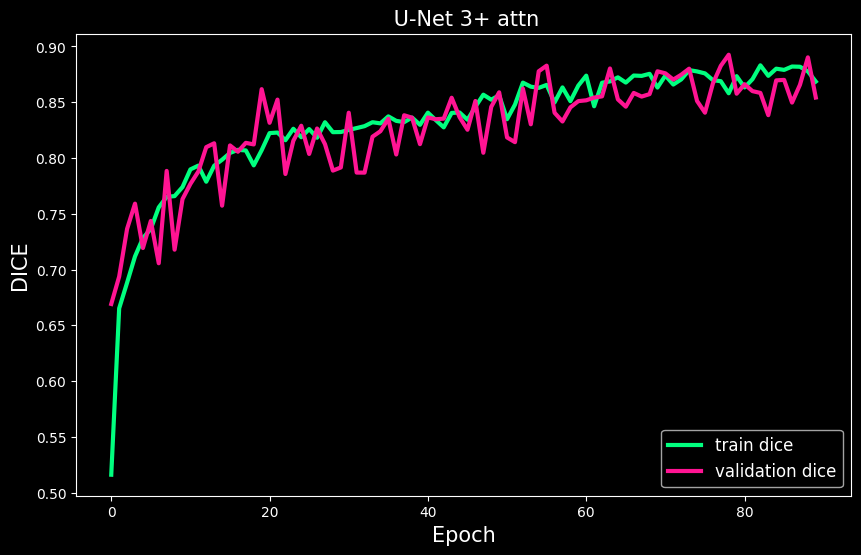

In [77]:
plot_model_history(" U-Net 3+ attn", aun_th_prev, aun_vh_prev, last_num_ep)

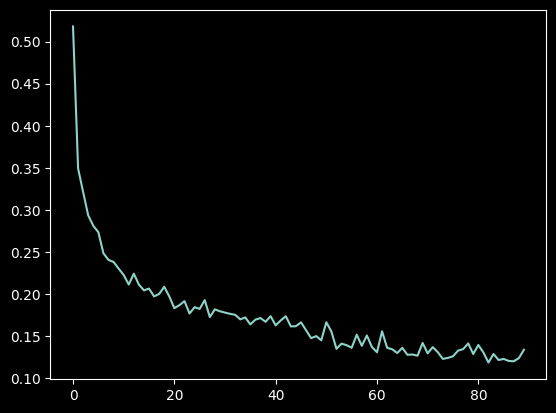

In [78]:
plt.plot(range(last_num_ep), aun_lh_prev)

In [79]:
test_iou = compute_iou(unet3p_attn, test_dataloader, device)
print(f"""U-Net 3+ Attention\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

U-Net 3+ Attention
Mean IoU of the test images - 85.0%


# U-Net 3+

In [ ]:
unet3p = UNet3Plus(n_classes=1).to(device)

In [ ]:
# PATH = "model_unet_3p.pt"

In [ ]:
opt_unet_3p = torch.optim.Adamax(unet3p.parameters(), lr=1e-3)

In [ ]:
# %%time
num_ep = 1
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_3p", unet3p, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p, False, num_ep, device=device)

In [ ]:
plot_model_history("U-Net 3+", aun_th, aun_vh, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(unet3p, test_dataloader)
print(f"""U-Net 3+\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")


# UNet with Attention

In [ ]:
attention_unet = AttentionUNet(n_classes=1).to(device)

In [ ]:
# PATH = "model_unet_with_attn.pt"

In [ ]:
opt_unet_attn = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

In [ ]:
# %%time
num_ep = 1
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_attn", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt_unet_attn, False, num_ep, device=device)

In [ ]:
plot_model_history("Attention U-Net", aun_th, aun_vh, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(attention_unet, test_dataloader)
print(f"""Attention U-Net\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

In [ ]:
#============================== EXP : viz pred mask

In [ ]:
# a = torch.zeros(4, 5, 6)
# a = a.unsqueeze(0)

# a.shape


In [ ]:
test_dataset.df.head(10)#[test_dataset.df['diagnosis']==1]

In [ ]:
test_dataset.df.loc[1103]

In [ ]:
test_dataset[1][1].sum()

In [ ]:
idx = 33
viz_pred_output(unet3p_attn, test_dataloader, idx, test_dataset, device)

In [ ]:
#==============================